# Setup enviorment

In [1]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [2]:
""" Read Dataset:"""

embeddings = 'Embeddings/variational_autoencoder_224_1024.csv'
temp_prec = ['../Tabular_data/precipitation_all.csv', '../Tabular_data/temperature_all 2.csv']
static = '../Tabular_data/dengue_tabular.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv('Embeddings/variational_autoencoder_224_1024.csv')['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T = 3
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [3]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality, temp_prec=temp_prec, static=static) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe fo

list

### Train Test split

In [4]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 1053)
The test shape is: (33, 1053)
The train shape is: (130, 1053)
The test shape is: (33, 1053)
The train shape is: (130, 1053)
The test shape is: (33, 1053)
The train shape is: (130, 1053)
The test shape is: (33, 1053)
The train shape is: (130, 1053)
The test shape is: (33, 1053)
The train shape is: (130, 1053)
The test shape is: (33, 1053)
The train shape is: (130, 1053)
The test shape is: (33, 1053)
The train shape is: (130, 1053)
The test shape is: (33, 1053)
The train shape is: (130, 1053)
The test shape is: (33, 1053)
The train shape is: (130, 1053)
The test shape is: (33, 1053)


### Normalize features

In [5]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [6]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0         1         2         3         4         5  \
41001 201546 -0.152315 -0.008257  0.229576 -0.459560 -0.115707 -0.250769   
      201547 -0.429644 -0.180829  0.196399  0.251703  0.151782  0.120646   
      201548 -0.161068  0.576082 -0.324825  0.105533  0.241237  0.022886   
      201549 -0.260170  0.167611 -0.298852  0.011480  0.048733  0.113631   
      201550  0.441330  0.225024  0.025560 -0.678361  0.065666 -0.795079   

                     6         7         8         9  ...  \
41001 201546 -0.473106 -0.372146 -0.407803  0.184894  ...   
      201547 -0.128355 -0.304024  0.658483 -0.437008  ...   
      201548  0.055301 -0.310014 -0.244395  0.053250  ...   
      201549 -0.398770 -0.094119  0.217093 -0.104882  ...   
      201550  0.085061 -0.637887  0.213285  0.176507  ...   

              Buildingstratification1(%)  Buildingstratification2(%)  \
41001 201546                    -0.38184                     0.90498   
      201547                    -0.38184                     0.90498   
      201548                    -0.38184                     0.90498   
      201549                    -0.38184                     0.90498   
      201550                    -0.38184                     0.90498   

              Buildingstratification3(%)  Buildingstratification4(%)  \
41001 201546                   -0.917415                   -0.851179   
      201547                   -0.917415                   -0.851179   
      201548                   -0.917415                   -0.851179   
      201549                   -0.917415                   -0.851179   
      201550                   -0.917415                   -0.851179   

              Buildingstratification5(%)  Buildingstratification6(%)  \
41001 201546                     -0.7492                   -0.981855   
      201547                     -0.7492                   -0.981855   
      201548                     -0.7492                   -0.981855   
      201549                     -0.7492                   -0.981855   
      201550                     -0.7492                   -0.981855   

              NumberofhospitalsperKm2  NumberofhousesperKm2  population  \
41001 201546                -0.990366               -0.9891   -0.924272   
      201547                -0.990366               -0.9891   -0.924272   
      201548                -0.990366               -0.9891   -0.924272   
      201549                -0.990366               -0.9891   -0.924272   
      201550                -0.990366               -0.9891   -0.924272   

                Labels  
41001 201546 -0.861740  
      201547 -0.854589  
      201548 -0.856973  
      201549 -0.856973  
      201550 -0.823600  

[5 rows x 1053 columns]

In [7]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

0         1         2         3         4         5  \
41001 201820  0.377501  0.058192 -0.121884  0.142221 -0.422123 -0.338568   
      201821  0.425911  0.212401 -0.038819 -0.400261  0.254694 -0.448073   
      201822 -0.069995  0.237755  0.151022 -0.046802  0.012595 -0.410129   
      201823  0.308861  0.156666  0.139823  0.301422 -0.530209 -0.318304   
      201824 -0.443093  0.134781 -0.274972  0.309000 -0.442412 -0.329776   

                     6         7         8         9  ...  \
41001 201820 -0.301512  0.143935  0.010483  0.500248  ...   
      201821  0.297020 -0.398212  0.184892  0.256703  ...   
      201822 -0.120283  0.390381 -0.328007  0.219778  ...   
      201823  0.175030  0.086659  0.598123  0.222864  ...   
      201824 -0.570991 -0.178042  0.269263  0.467060  ...   

              Buildingstratification1(%)  Buildingstratification2(%)  \
41001 201820                    -0.38184                     0.90498   
      201821                    -0.38184                     0.90498   
      201822                    -0.38184                     0.90498   
      201823                    -0.38184                     0.90498   
      201824                    -0.38184                     0.90498   

              Buildingstratification3(%)  Buildingstratification4(%)  \
41001 201820                   -0.917415                   -0.851179   
      201821                   -0.917415                   -0.851179   
      201822                   -0.917415                   -0.851179   
      201823                   -0.917415                   -0.851179   
      201824                   -0.917415                   -0.851179   

              Buildingstratification5(%)  Buildingstratification6(%)  \
41001 201820                     -0.7492                   -0.981855   
      201821                     -0.7492                   -0.981855   
      201822                     -0.7492                   -0.981855   
      201823                     -0.7492                   -0.981855   
      201824                     -0.7492                   -0.981855   

              NumberofhospitalsperKm2  NumberofhousesperKm2  population  \
41001 201820                -0.990366               -0.9891   -0.924272   
      201821                -0.990366               -0.9891   -0.924272   
      201822                -0.990366               -0.9891   -0.924272   
      201823                -0.990366               -0.9891   -0.924272   
      201824                -0.990366               -0.9891   -0.924272   

                Labels  
41001 201820 -0.949940  
      201821 -0.961859  
      201822 -0.940405  
      201823 -0.961859  
      201824 -0.954708  

[5 rows x 1053 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [8]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(128, 3157)

### Merge train data

In [9]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

In [10]:
train.shape

(1280, 3157)

### Features and Labels Set

In [11]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1280, 3156)
The shape of the labels is (1280, 1)
Test:
The shape of the features is (310, 3156)
The shape of the labels is (310, 1)


In [12]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

The initial shapes are:
The train shape is (1280, 3156)
The test shape is (310, 3156)
-----------------------
The Final shapes are:
The train shape is (1280, 3, 1052)
The test shape is (310, 3, 1052)


# 2. Model

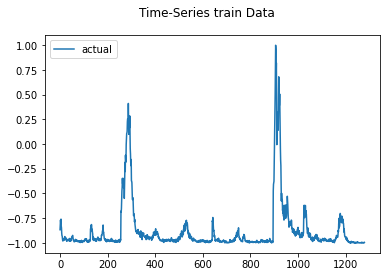

2023-03-10 22:55:16.652156: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-10 22:55:16.652198: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-10 22:55:16.652219: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9e0b1a08816a): /proc/driver/nvidia/version does not exist
2023-03-10 22:55:16.652438: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 22:55:18.064446: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 40.600
Test RMSE: 48.638
Test sMAPE: 97.469
Test R Squared: -1.384
{'mae': 40.59992935503683, 'rmse': 48.637555673341204, 'smape': 97.46870997490215, 'r2': -1.3843961743359507}


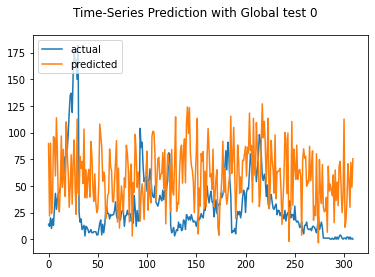

Test MAE: 45.704
Test RMSE: 60.878
Test sMAPE: 97.282
Test R Squared: -2.736
{'mae': 45.70396693771885, 'rmse': 60.87841738411187, 'smape': 97.28194209010557, 'r2': -2.735610970812991}


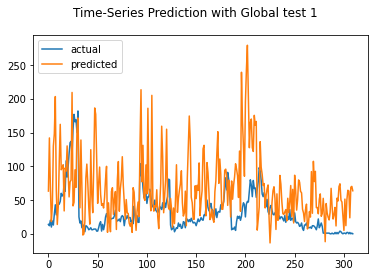

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 38.542
Test RMSE: 46.736
Test sMAPE: 102.911
Test R Squared: -1.202
{'mae': 38.541565324221885, 'rmse': 46.736420189034625, 'smape': 102.91103681961872, 'r2': -1.2016375459848239}


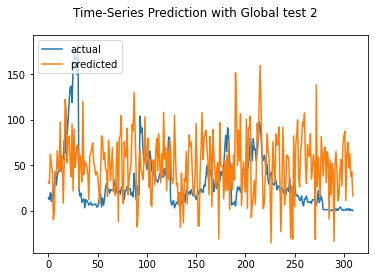

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 30.565
Test RMSE: 41.232
Test sMAPE: 100.547
Test R Squared: -0.714
{'mae': 30.565013673997694, 'rmse': 41.23154211973897, 'smape': 100.54747349698013, 'r2': -0.7135393859125716}


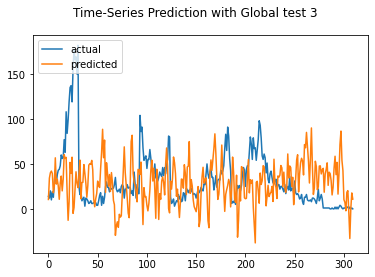

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 43.945
Test RMSE: 53.842
Test sMAPE: 105.737
Test R Squared: -1.922
{'mae': 43.94504972907804, 'rmse': 53.841600035994894, 'smape': 105.7366165382981, 'r2': -1.9219370115092649}


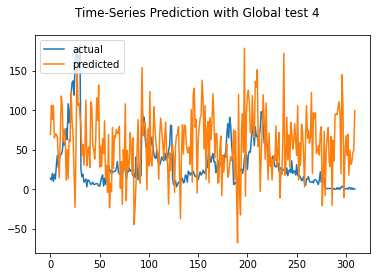

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 31.948
Test RMSE: 41.682
Test sMAPE: 108.406
Test R Squared: -0.751
{'mae': 31.94807757600661, 'rmse': 41.68187189788583, 'smape': 108.40624587339518, 'r2': -0.7511742539964821}


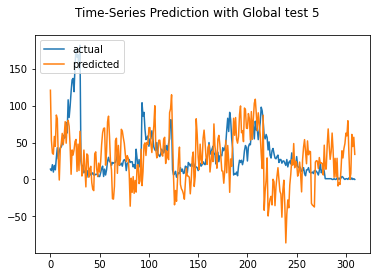

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 31.284
Test RMSE: 39.579
Test sMAPE: 90.963
Test R Squared: -0.579
{'mae': 31.284300512844517, 'rmse': 39.579498137616476, 'smape': 90.96252934324585, 'r2': -0.578975897524042}


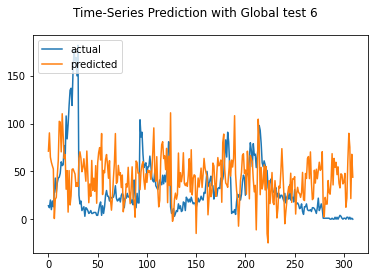

Test MAE: 38.639
Test RMSE: 44.103
Test sMAPE: 94.393
Test R Squared: -0.961
{'mae': 38.6389790750319, 'rmse': 44.10295987902001, 'smape': 94.39295599818058, 'r2': -0.9605160810595694}


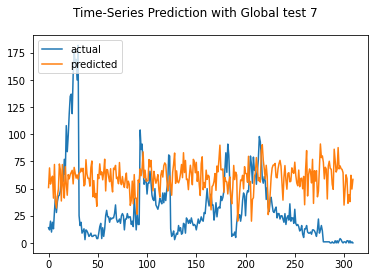

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 33.783
Test RMSE: 43.499
Test sMAPE: 89.718
Test R Squared: -0.907
{'mae': 33.783320121419045, 'rmse': 43.499286607278044, 'smape': 89.71825275837269, 'r2': -0.9072130230452835}


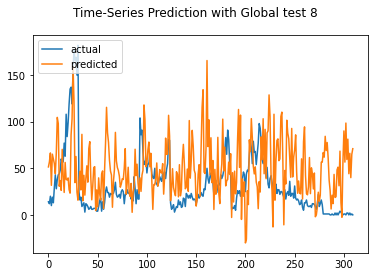

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 40.835
Test RMSE: 53.709
Test sMAPE: 137.927
Test R Squared: -1.908
{'mae': 40.83452849926487, 'rmse': 53.7087256777285, 'smape': 137.9267784959628, 'r2': -1.9075328545707118}


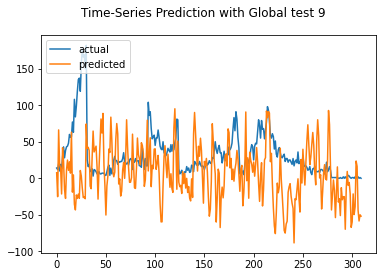

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 31.781
Test RMSE: 39.993
Test sMAPE: 86.634
Test R Squared: -0.612
{'mae': 31.7808507723193, 'rmse': 39.99322574283542, 'smape': 86.63430512119967, 'r2': -0.6121587455979196}


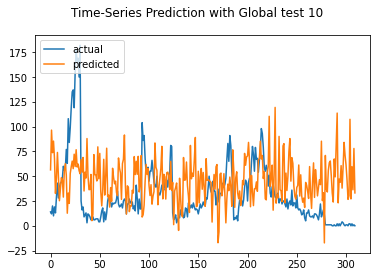

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 38.161
Test RMSE: 53.153
Test sMAPE: 121.410
Test R Squared: -1.848
{'mae': 38.16107452127241, 'rmse': 53.15308644602128, 'smape': 121.40989297281797, 'r2': -1.8476847540547032}


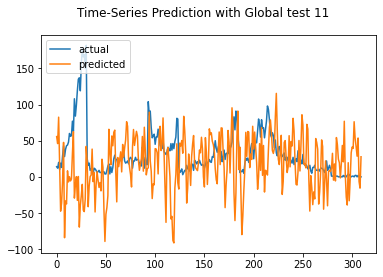

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 34.118
Test RMSE: 43.492
Test sMAPE: 92.347
Test R Squared: -0.907
{'mae': 34.11813439784512, 'rmse': 43.49171116227119, 'smape': 92.34739219691834, 'r2': -0.9065487947126665}


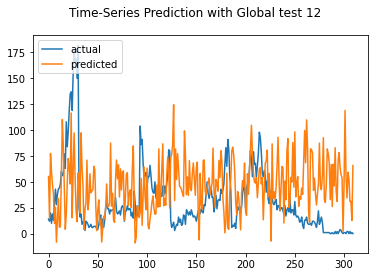

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Test MAE: 46.708
Test RMSE: 55.725
Test sMAPE: 102.628
Test R Squared: -2.130
{'mae': 46.70846234060103, 'rmse': 55.72455388011732, 'smape': 102.62755930261285, 'r2': -2.129883229440508}


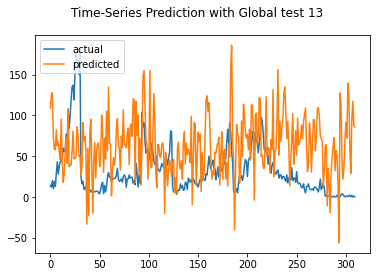

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 32.076
Test RMSE: 43.151
Test sMAPE: 103.336
Test R Squared: -0.877
{'mae': 32.07607997521277, 'rmse': 43.150588213336604, 'smape': 103.33559107417128, 'r2': -0.8767584285505818}


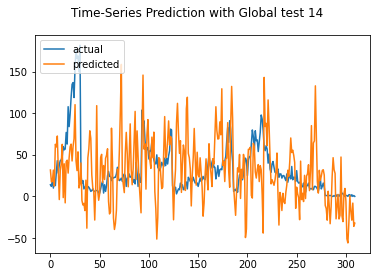

Test MAE: 35.819
Test RMSE: 41.439
Test sMAPE: 92.736
Test R Squared: -0.731
{'mae': 35.81898373019311, 'rmse': 41.43926854870553, 'smape': 92.73646276508646, 'r2': -0.7308486612399019}


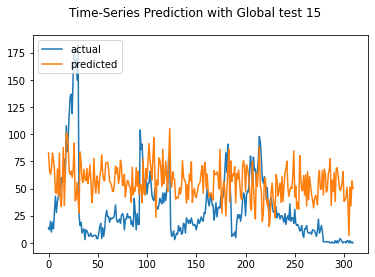

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 38.451
Test RMSE: 51.558
Test sMAPE: 112.194
Test R Squared: -1.679
{'mae': 38.45052641601332, 'rmse': 51.55755307396473, 'smape': 112.1936121693166, 'r2': -1.6792888054003265}


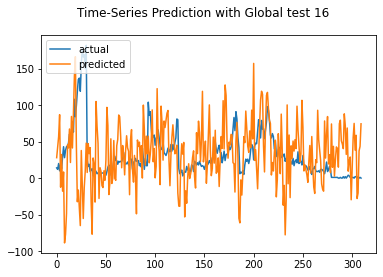

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 39.170
Test RMSE: 48.265
Test sMAPE: 107.842
Test R Squared: -1.348
{'mae': 39.1697922314367, 'rmse': 48.26512386213799, 'smape': 107.84154949123341, 'r2': -1.348019960865106}


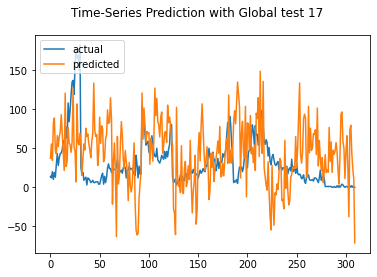

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 34.492
Test RMSE: 45.411
Test sMAPE: 113.377
Test R Squared: -1.079
{'mae': 34.49242684129746, 'rmse': 45.410989978788386, 'smape': 113.37704373875825, 'r2': -1.0785327611583537}


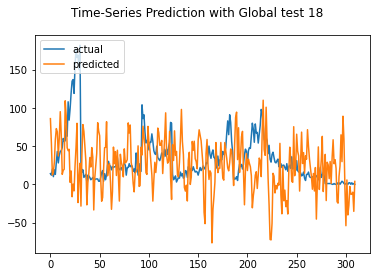

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 30.383
Test RMSE: 41.129
Test sMAPE: 116.782
Test R Squared: -0.705
{'mae': 30.382701906561852, 'rmse': 41.12851172059777, 'smape': 116.78213353815836, 'r2': -0.7049864161112134}


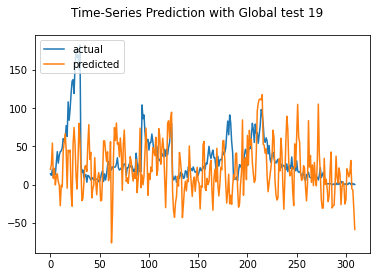

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 41.616
Test RMSE: 50.976
Test sMAPE: 107.961
Test R Squared: -1.619
{'mae': 41.615513866370726, 'rmse': 50.976066392009116, 'smape': 107.96127401926529, 'r2': -1.6191934379220694}


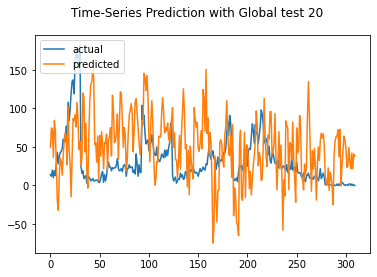

Test MAE: 48.743
Test RMSE: 54.443
Test sMAPE: 103.156
Test R Squared: -1.988
{'mae': 48.74261347247708, 'rmse': 54.44317615965372, 'smape': 103.1555289203118, 'r2': -1.987595809622189}


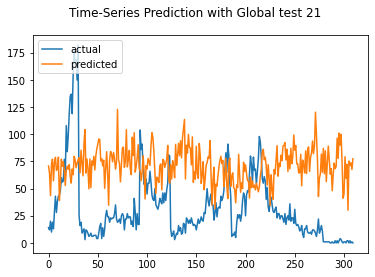

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 41.990
Test RMSE: 53.334
Test sMAPE: 105.857
Test R Squared: -1.867
{'mae': 41.99036998556506, 'rmse': 53.333621237028204, 'smape': 105.8572767213531, 'r2': -1.8670619638754817}


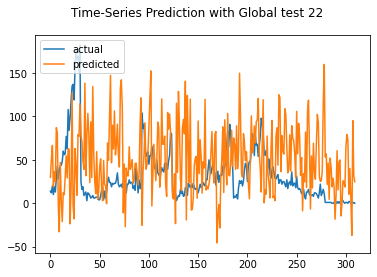

Test MAE: 40.176
Test RMSE: 45.576
Test sMAPE: 96.935
Test R Squared: -1.094
{'mae': 40.17590158216415, 'rmse': 45.57590721522297, 'smape': 96.93492742148118, 'r2': -1.093657219784025}


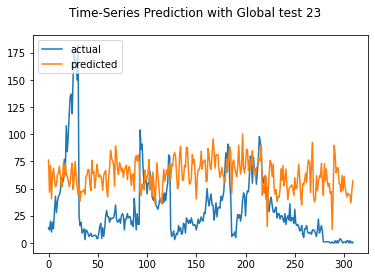

Test MAE: 39.609
Test RMSE: 49.637
Test sMAPE: 106.659
Test R Squared: -1.483
{'mae': 39.609111693789885, 'rmse': 49.63727461016935, 'smape': 106.65929632345677, 'r2': -1.4834235239416187}


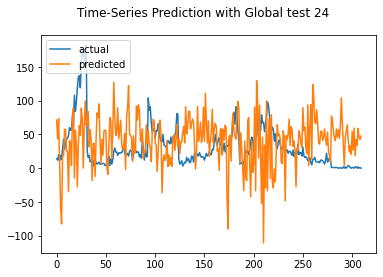

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 36.010
Test RMSE: 46.303
Test sMAPE: 100.832
Test R Squared: -1.161
{'mae': 36.010213331830116, 'rmse': 46.30256148222494, 'smape': 100.83165064083299, 'r2': -1.1609512456854838}


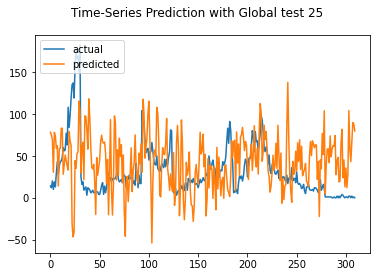

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 35.265
Test RMSE: 42.980
Test sMAPE: 91.791
Test R Squared: -0.862
{'mae': 35.26527846013346, 'rmse': 42.9803457267475, 'smape': 91.79066546579291, 'r2': -0.8619788501737882}


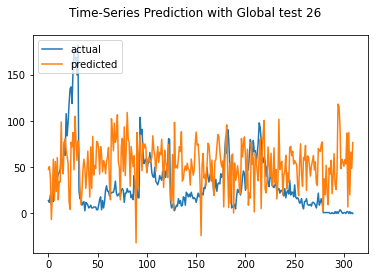

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 39.243
Test RMSE: 47.590
Test sMAPE: 100.312
Test R Squared: -1.283
{'mae': 39.242615980294445, 'rmse': 47.589794711481275, 'smape': 100.3120465248512, 'r2': -1.2827723170075465}


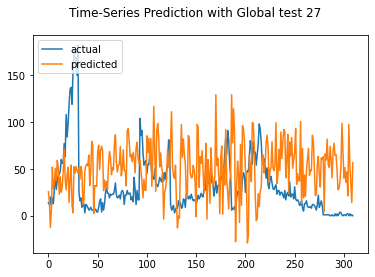

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 42.187
Test RMSE: 50.908
Test sMAPE: 107.601
Test R Squared: -1.612
{'mae': 42.18691066657343, 'rmse': 50.90844425739291, 'smape': 107.60111293068694, 'r2': -1.6122490819601234}


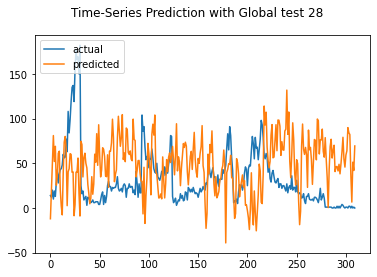

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Test MAE: 41.420
Test RMSE: 51.334
Test sMAPE: 101.042
Test R Squared: -1.656
{'mae': 41.42025933304141, 'rmse': 51.333548162355804, 'smape': 101.04249362025728, 'r2': -1.656057677765467}


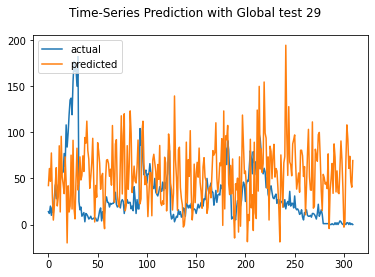

Test MAE: 41.798
Test RMSE: 48.344
Test sMAPE: 98.694
Test R Squared: -1.356
{'mae': 41.79786893629259, 'rmse': 48.344123177155, 'smape': 98.69424163978455, 'r2': -1.3557126282956924}


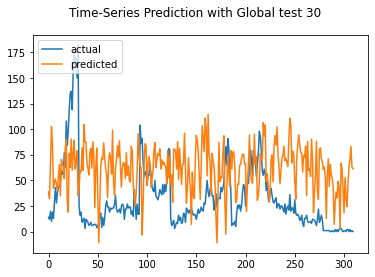

Test MAE: 44.950
Test RMSE: 50.564
Test sMAPE: 100.204
Test R Squared: -1.577
{'mae': 44.95021619489116, 'rmse': 50.56399327734047, 'smape': 100.2043635825551, 'r2': -1.5770192596900259}


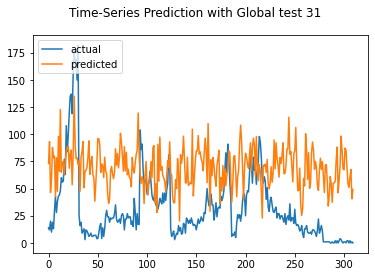

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 39.129
Test RMSE: 47.967
Test sMAPE: 99.369
Test R Squared: -1.319
{'mae': 39.12910401109726, 'rmse': 47.96738813073619, 'smape': 99.36946228388165, 'r2': -1.3191405908839187}


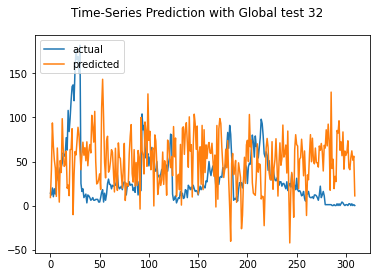

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 25.472
Test RMSE: 34.904
Test sMAPE: 88.444
Test R Squared: -0.228
{'mae': 25.471778536996535, 'rmse': 34.90428926586268, 'smape': 88.44364482561643, 'r2': -0.22798350409043033}


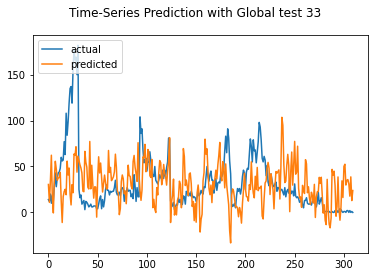

Test MAE: 41.565
Test RMSE: 47.381
Test sMAPE: 97.199
Test R Squared: -1.263
{'mae': 41.56518095693281, 'rmse': 47.381045939558, 'smape': 97.198904791524, 'r2': -1.2627898480976594}


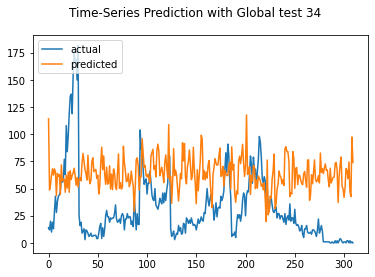

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Test MAE: 39.200
Test RMSE: 49.956
Test sMAPE: 104.591
Test R Squared: -1.515
{'mae': 39.20022792085525, 'rmse': 49.95593158399426, 'smape': 104.59073216343411, 'r2': -1.515411596743665}


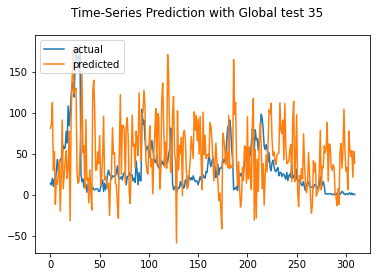

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Test MAE: 42.580
Test RMSE: 50.533
Test sMAPE: 98.988
Test R Squared: -1.574
{'mae': 42.579530931576606, 'rmse': 50.53281337628999, 'smape': 98.98755036293655, 'r2': -1.5738420410276257}


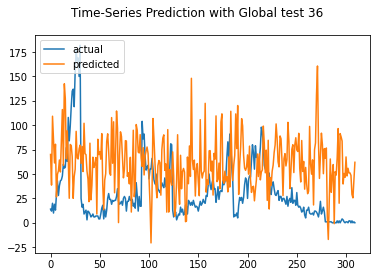

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Test MAE: 38.653
Test RMSE: 48.804
Test sMAPE: 98.615
Test R Squared: -1.401
{'mae': 38.65268930081398, 'rmse': 48.80447144685819, 'smape': 98.61497775565547, 'r2': -1.4007899362681737}


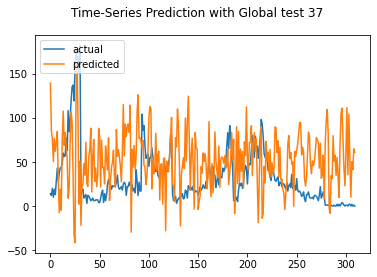

Test MAE: 43.266
Test RMSE: 53.034
Test sMAPE: 94.542
Test R Squared: -1.835
{'mae': 43.26619227317072, 'rmse': 53.03446350858286, 'smape': 94.54204562012255, 'r2': -1.834988453077834}


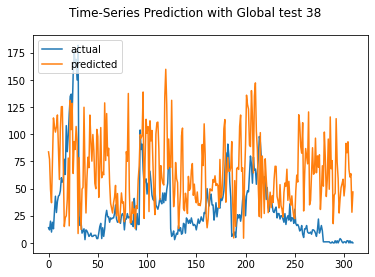

Test MAE: 36.705
Test RMSE: 55.537
Test sMAPE: 87.364
Test R Squared: -2.109
{'mae': 36.70521667926542, 'rmse': 55.53726439020571, 'smape': 87.36391181080766, 'r2': -2.108879592901978}


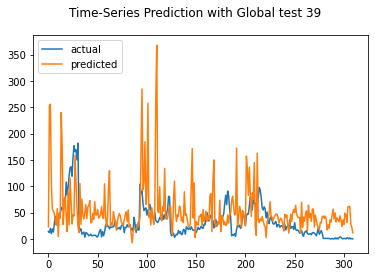

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Test MAE: 41.406
Test RMSE: 49.885
Test sMAPE: 103.396
Test R Squared: -1.508
{'mae': 41.405740938263556, 'rmse': 49.88484617883571, 'smape': 103.39582869852184, 'r2': -1.5082580184772625}


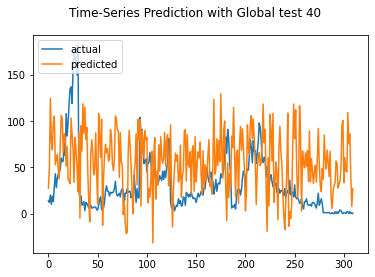

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 44.755
Test RMSE: 56.430
Test sMAPE: 118.521
Test R Squared: -2.210
{'mae': 44.75541373606651, 'rmse': 56.42960256039601, 'smape': 118.52057913637151, 'r2': -2.2095852647145207}


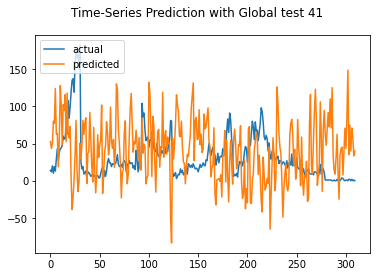

Test MAE: 38.577
Test RMSE: 43.782
Test sMAPE: 95.509
Test R Squared: -0.932
{'mae': 38.57698323649745, 'rmse': 43.781704143830154, 'smape': 95.5087056132869, 'r2': -0.932058438450923}


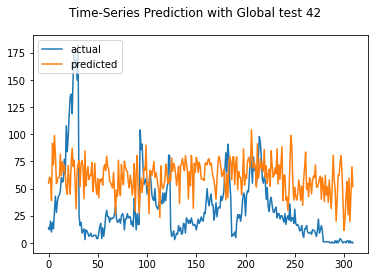

Test MAE: 49.932
Test RMSE: 56.876
Test sMAPE: 107.283
Test R Squared: -2.261
{'mae': 49.93190464742722, 'rmse': 56.87645322389194, 'smape': 107.28279206418362, 'r2': -2.2606181900045987}


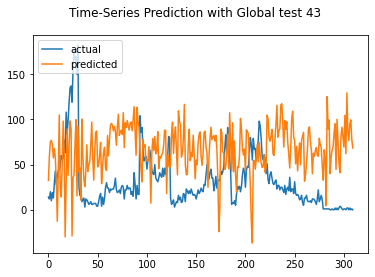

Test MAE: 43.326
Test RMSE: 49.521
Test sMAPE: 98.133
Test R Squared: -1.472
{'mae': 43.325947927659556, 'rmse': 49.521234250144346, 'smape': 98.13274227354249, 'r2': -1.471825767361397}


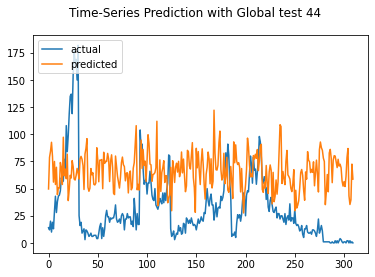

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 37.208
Test RMSE: 48.896
Test sMAPE: 107.728
Test R Squared: -1.410
{'mae': 37.20813493084523, 'rmse': 48.89630861852898, 'smape': 107.72817287297906, 'r2': -1.4098337470216715}


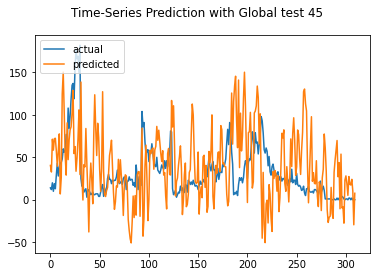

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 40.366
Test RMSE: 47.719
Test sMAPE: 97.272
Test R Squared: -1.295
{'mae': 40.36628981847917, 'rmse': 47.71923253067834, 'smape': 97.27223522130107, 'r2': -1.295206869461854}


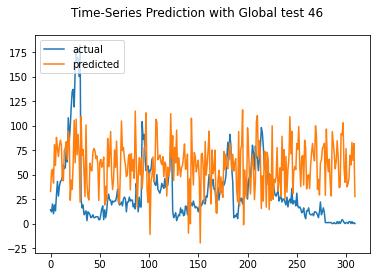

Test MAE: 50.459
Test RMSE: 57.445
Test sMAPE: 107.181
Test R Squared: -2.326
{'mae': 50.45925105906302, 'rmse': 57.4449419396366, 'smape': 107.18087222156953, 'r2': -2.326124675396445}


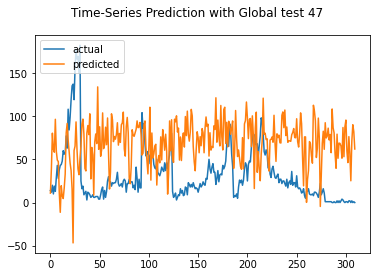

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 38.899
Test RMSE: 50.133
Test sMAPE: 103.377
Test R Squared: -1.533
{'mae': 38.89921198621873, 'rmse': 50.13272145551276, 'smape': 103.37731654103182, 'r2': -1.533246762887749}


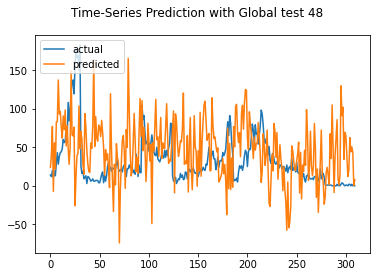

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 37.000
Test RMSE: 47.503
Test sMAPE: 111.366
Test R Squared: -1.274
{'mae': 36.99987714809756, 'rmse': 47.502888277655934, 'smape': 111.36570658378452, 'r2': -1.2744425286963907}


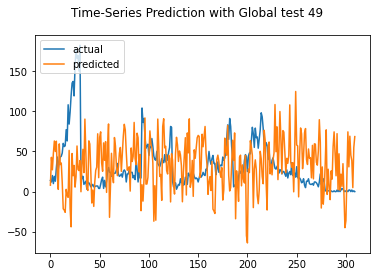

Test MAE: 40.988
Test RMSE: 53.450
Test sMAPE: 100.937
Test R Squared: -1.880
{'mae': 40.988132576980895, 'rmse': 53.4498510548985, 'smape': 100.93679913510287, 'r2': -1.8795719414312804}


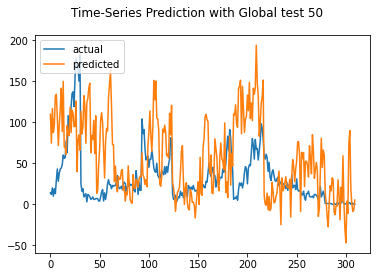

Test MAE: 39.156
Test RMSE: 45.216
Test sMAPE: 95.516
Test R Squared: -1.061
{'mae': 39.156117814587006, 'rmse': 45.215914105875996, 'smape': 95.51568536080396, 'r2': -1.0607132560803203}


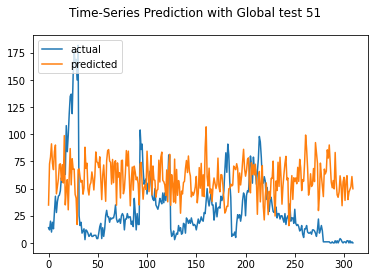

Test MAE: 41.189
Test RMSE: 46.964
Test sMAPE: 96.606
Test R Squared: -1.223
{'mae': 41.18902765089466, 'rmse': 46.96444918414686, 'smape': 96.60635066073338, 'r2': -1.223173723795048}


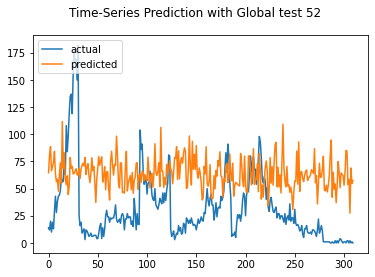

Test MAE: 41.987
Test RMSE: 47.205
Test sMAPE: 98.617
Test R Squared: -1.246
{'mae': 41.98745798910818, 'rmse': 47.20509793640494, 'smape': 98.61740545641909, 'r2': -1.2460154557351397}


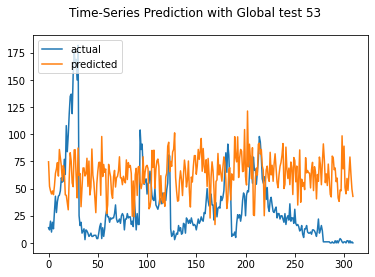

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 38.831
Test RMSE: 48.849
Test sMAPE: 103.385
Test R Squared: -1.405
{'mae': 38.83097987290352, 'rmse': 48.84897131185141, 'smape': 103.38457458942653, 'r2': -1.4051700076351388}


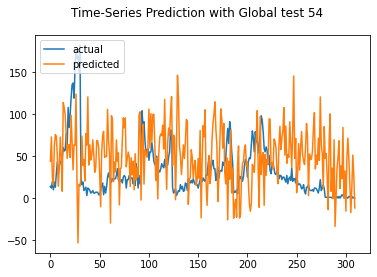

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 51.646
Test RMSE: 65.021
Test sMAPE: 121.390
Test R Squared: -3.261
{'mae': 51.645513667118166, 'rmse': 65.02081071726292, 'smape': 121.38962725075, 'r2': -3.261276302939425}


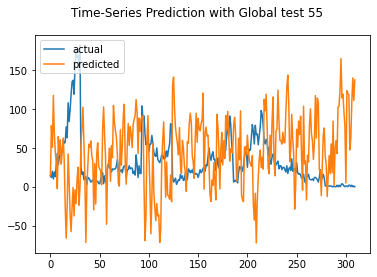

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 29.467
Test RMSE: 37.835
Test sMAPE: 102.528
Test R Squared: -0.443
{'mae': 29.466890662812418, 'rmse': 37.83525015281198, 'smape': 102.52815678386877, 'r2': -0.4428731569016544}


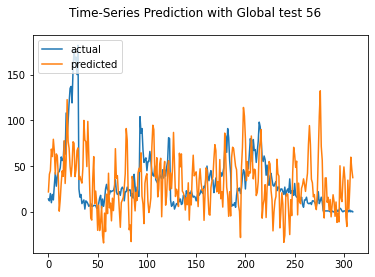

Test MAE: 36.180
Test RMSE: 45.736
Test sMAPE: 99.326
Test R Squared: -1.108
{'mae': 36.18019653520277, 'rmse': 45.73555306790644, 'smape': 99.32550450257202, 'r2': -1.108350469632267}


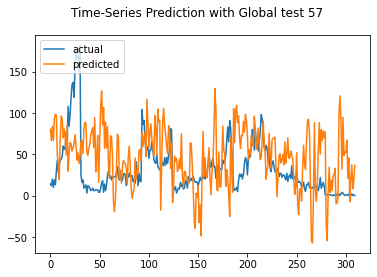

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 42.585
Test RMSE: 56.616
Test sMAPE: 137.618
Test R Squared: -2.231
{'mae': 42.58470745278943, 'rmse': 56.616366215036784, 'smape': 137.6180052820876, 'r2': -2.2308657916855177}


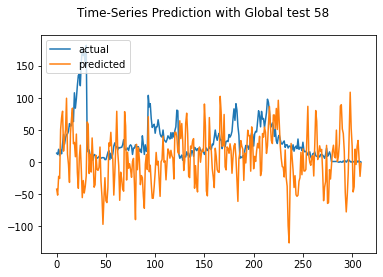

Test MAE: 39.207
Test RMSE: 44.972
Test sMAPE: 95.405
Test R Squared: -1.039
{'mae': 39.20665124462497, 'rmse': 44.971973194195975, 'smape': 95.40513128635747, 'r2': -1.038538043567263}


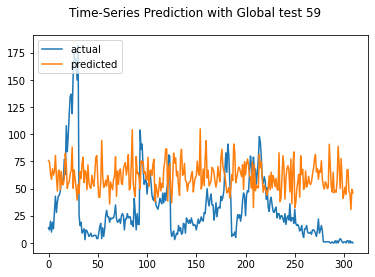

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 40.598
Test RMSE: 50.244
Test sMAPE: 99.413
Test R Squared: -1.544
{'mae': 40.598186936493846, 'rmse': 50.2438175762403, 'smape': 99.41255312258963, 'r2': -1.544486756026457}


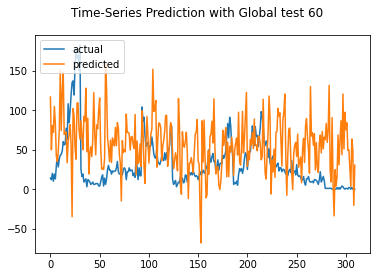

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 36.730
Test RMSE: 43.881
Test sMAPE: 90.816
Test R Squared: -0.941
{'mae': 36.73043580824329, 'rmse': 43.88142929647457, 'smape': 90.81571831879225, 'r2': -0.9408700761900699}


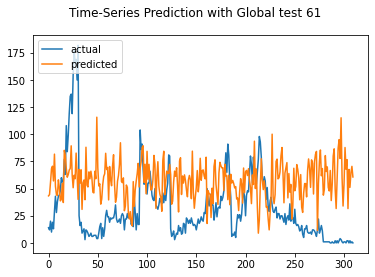

Test MAE: 41.760
Test RMSE: 47.987
Test sMAPE: 97.789
Test R Squared: -1.321
{'mae': 41.75993033378355, 'rmse': 47.98740120403208, 'smape': 97.7890441081178, 'r2': -1.3210761898289087}


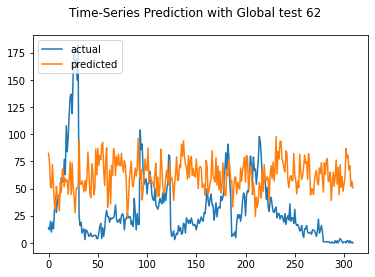

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 41.695
Test RMSE: 51.232
Test sMAPE: 104.178
Test R Squared: -1.646
{'mae': 41.69502978882482, 'rmse': 51.231572976966156, 'smape': 104.17797182173875, 'r2': -1.6455155291247419}


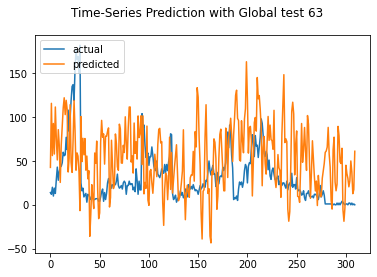

Test MAE: 41.961
Test RMSE: 49.233
Test sMAPE: 102.266
Test R Squared: -1.443
{'mae': 41.96073826935984, 'rmse': 49.23300222900929, 'smape': 102.26555074337062, 'r2': -1.4431356121875578}


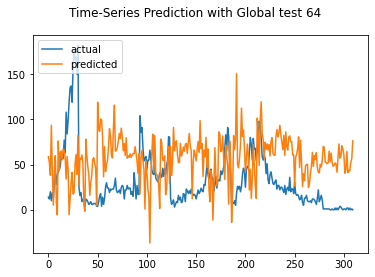

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 41.021
Test RMSE: 53.375
Test sMAPE: 136.185
Test R Squared: -1.871
{'mae': 41.02082046251143, 'rmse': 53.374829329780795, 'smape': 136.18518556778557, 'r2': -1.871494132374948}


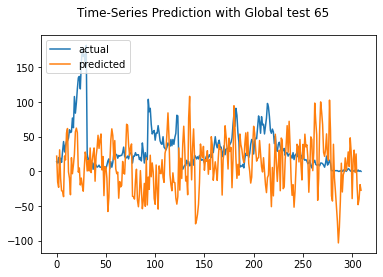

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 35.361
Test RMSE: 43.690
Test sMAPE: 91.296
Test R Squared: -0.924
{'mae': 35.36143303763482, 'rmse': 43.689554875837246, 'smape': 91.29614980577645, 'r2': -0.9239340215348455}


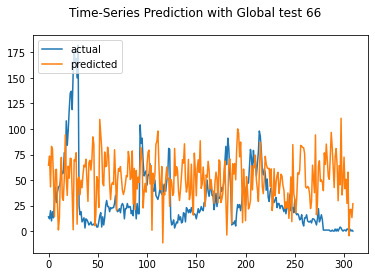

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 39.681
Test RMSE: 48.199
Test sMAPE: 107.773
Test R Squared: -1.342
{'mae': 39.681340555125665, 'rmse': 48.19875770297391, 'smape': 107.7730295152372, 'r2': -1.341567188391152}


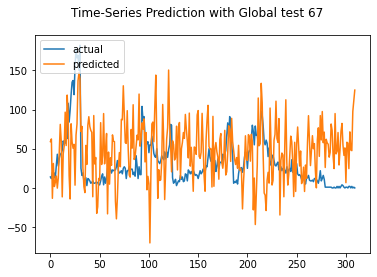

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 38.381
Test RMSE: 46.835
Test sMAPE: 95.405
Test R Squared: -1.211
{'mae': 38.38118608709305, 'rmse': 46.8352493275356, 'smape': 95.40498216348306, 'r2': -1.2109585849264035}


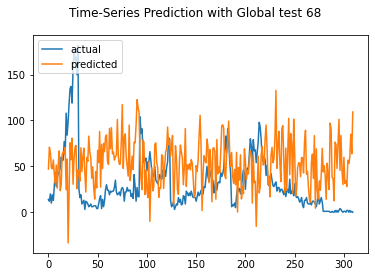

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 43.096
Test RMSE: 54.150
Test sMAPE: 123.426
Test R Squared: -1.955
{'mae': 43.095744565513826, 'rmse': 54.14976799445439, 'smape': 123.4264370458509, 'r2': -1.9554807496121929}


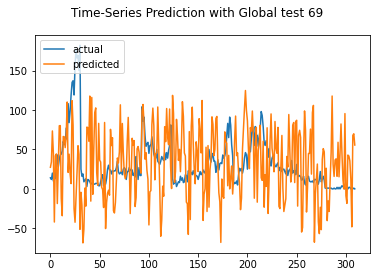

Test MAE: 46.256
Test RMSE: 64.717
Test sMAPE: 114.870
Test R Squared: -3.221
{'mae': 46.25647517779181, 'rmse': 64.71658842860646, 'smape': 114.86950373990973, 'r2': -3.221493887251441}


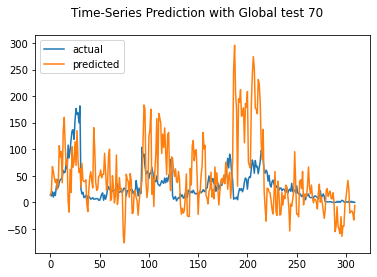

Test MAE: 41.971
Test RMSE: 47.757
Test sMAPE: 97.725
Test R Squared: -1.299
{'mae': 41.97085401473507, 'rmse': 47.756581923352975, 'smape': 97.72469778857847, 'r2': -1.2988011490007203}


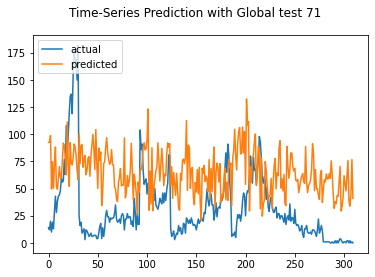

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 43.161
Test RMSE: 52.805
Test sMAPE: 103.150
Test R Squared: -1.811
{'mae': 43.160903754349675, 'rmse': 52.80547610018267, 'smape': 103.15028943027113, 'r2': -1.8105599913667967}


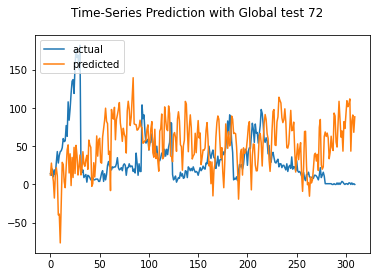

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Test MAE: 41.402
Test RMSE: 52.300
Test sMAPE: 101.976
Test R Squared: -1.757
{'mae': 41.40171457759796, 'rmse': 52.29969778367156, 'smape': 101.9762722507664, 'r2': -1.7569779523758329}


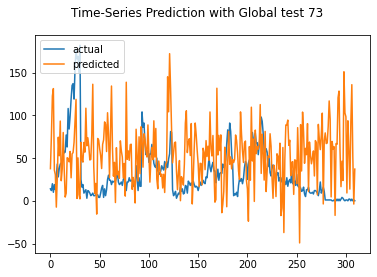

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 36.751
Test RMSE: 45.574
Test sMAPE: 94.603
Test R Squared: -1.093
{'mae': 36.75113693475724, 'rmse': 45.57407178611344, 'smape': 94.60266218525123, 'r2': -1.093488592003966}


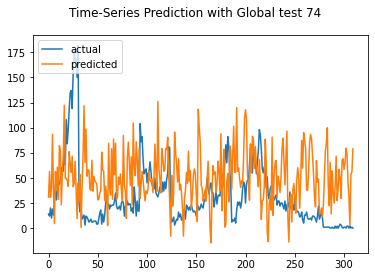

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 38.276
Test RMSE: 47.989
Test sMAPE: 92.395
Test R Squared: -1.321
{'mae': 38.27639358524353, 'rmse': 47.98887306843107, 'smape': 92.39505781989853, 'r2': -1.3212185756100832}


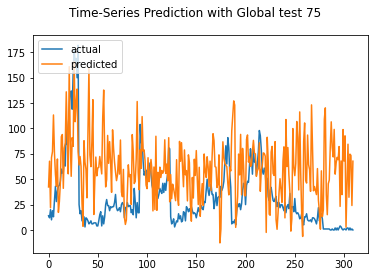

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 38.864
Test RMSE: 47.305
Test sMAPE: 103.109
Test R Squared: -1.256
{'mae': 38.86445909478972, 'rmse': 47.30486578447097, 'smape': 103.1089271606142, 'r2': -1.2555193836973237}


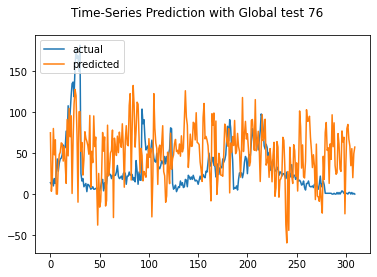

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Test MAE: 42.975
Test RMSE: 53.382
Test sMAPE: 117.513
Test R Squared: -1.872
{'mae': 42.974872170532905, 'rmse': 53.381589297761465, 'smape': 117.51283416123891, 'r2': -1.8722215328316203}


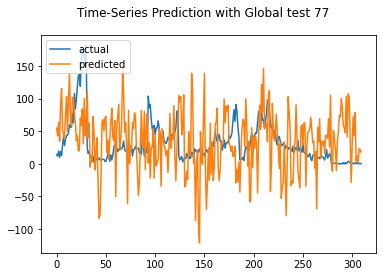

Test MAE: 39.584
Test RMSE: 45.930
Test sMAPE: 95.104
Test R Squared: -1.126
{'mae': 39.58388294558371, 'rmse': 45.92962982527109, 'smape': 95.10440427473849, 'r2': -1.1262818148259388}


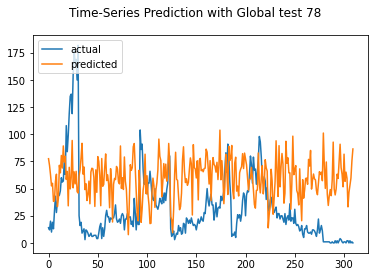

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 43.454
Test RMSE: 51.746
Test sMAPE: 97.567
Test R Squared: -1.699
{'mae': 43.4537187668585, 'rmse': 51.745811612186124, 'smape': 97.5671709847457, 'r2': -1.6988909723534755}


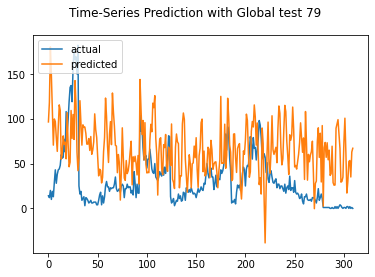

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 36.566
Test RMSE: 43.883
Test sMAPE: 93.553
Test R Squared: -0.941
{'mae': 36.56637013170027, 'rmse': 43.88266333843791, 'smape': 93.55317338336644, 'r2': -0.9409792407654154}


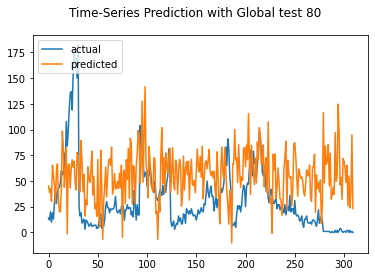

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 38.214
Test RMSE: 48.496
Test sMAPE: 122.943
Test R Squared: -1.371
{'mae': 38.21444170013551, 'rmse': 48.49583524304935, 'smape': 122.94348605304545, 'r2': -1.3705210799237717}


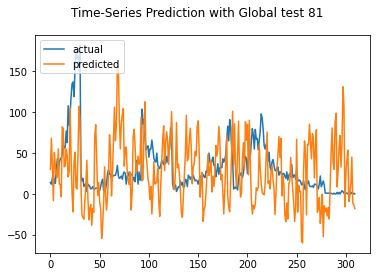

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Test MAE: 38.353
Test RMSE: 44.995
Test sMAPE: 99.079
Test R Squared: -1.041
{'mae': 38.353091791752846, 'rmse': 44.9948281515335, 'smape': 99.07903103866364, 'r2': -1.040610558314}


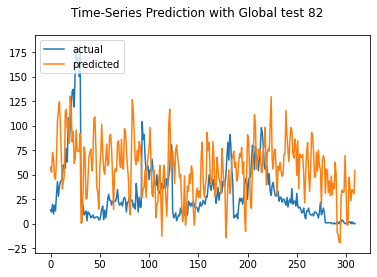

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 35.336
Test RMSE: 43.344
Test sMAPE: 93.437
Test R Squared: -0.894
{'mae': 35.336100212989315, 'rmse': 43.34444958765861, 'smape': 93.43692094884285, 'r2': -0.8936596236283263}


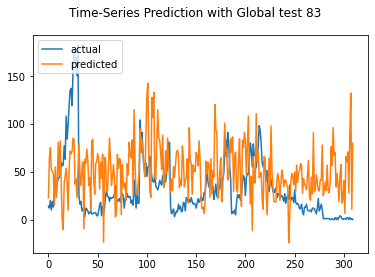

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 39.448
Test RMSE: 48.951
Test sMAPE: 102.623
Test R Squared: -1.415
{'mae': 39.44805024670016, 'rmse': 48.951446780965576, 'smape': 102.62341375335284, 'r2': -1.4152717330882556}


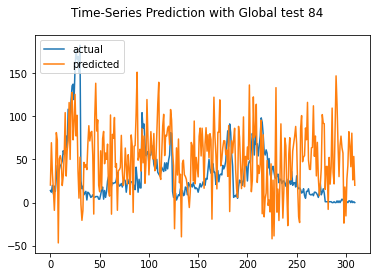

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 40.056
Test RMSE: 50.500
Test sMAPE: 125.132
Test R Squared: -1.571
{'mae': 40.05622450661275, 'rmse': 50.500146036879585, 'smape': 125.13208565566826, 'r2': -1.5705153553099804}


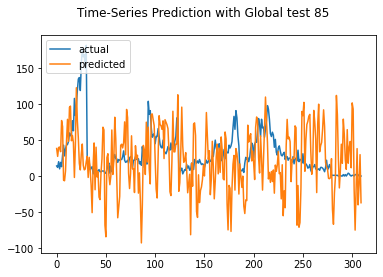

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 29.971
Test RMSE: 37.729
Test sMAPE: 92.073
Test R Squared: -0.435
{'mae': 29.970668700049, 'rmse': 37.72917988796656, 'smape': 92.07333001114618, 'r2': -0.4347943728646795}


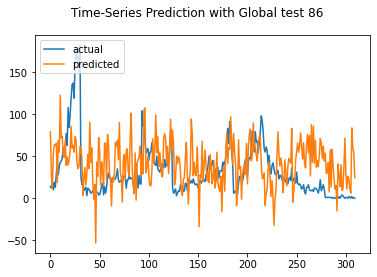

Test MAE: 41.205
Test RMSE: 46.533
Test sMAPE: 97.280
Test R Squared: -1.183
{'mae': 41.20506082350208, 'rmse': 46.532994254155064, 'smape': 97.27990110059564, 'r2': -1.1825134680331395}


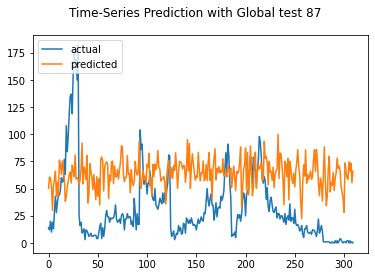

Test MAE: 47.179
Test RMSE: 52.774
Test sMAPE: 102.446
Test R Squared: -1.807
{'mae': 47.178694614287345, 'rmse': 52.7738030542508, 'smape': 102.44631378388816, 'r2': -1.807189420539471}


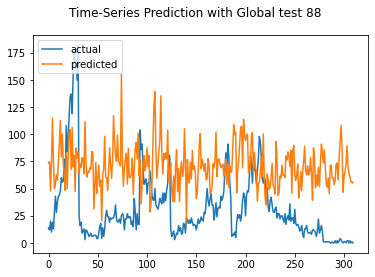

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 31.262
Test RMSE: 38.736
Test sMAPE: 90.510
Test R Squared: -0.512
{'mae': 31.262464548887746, 'rmse': 38.735800787580715, 'smape': 90.50988530323744, 'r2': -0.5123768175841688}


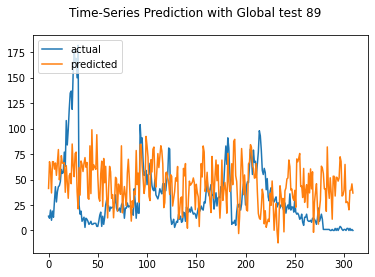

Test MAE: 44.242
Test RMSE: 56.884
Test sMAPE: 114.154
Test R Squared: -2.261
{'mae': 44.24158006272008, 'rmse': 56.88404098428561, 'smape': 114.15418074940656, 'r2': -2.2614882315935247}


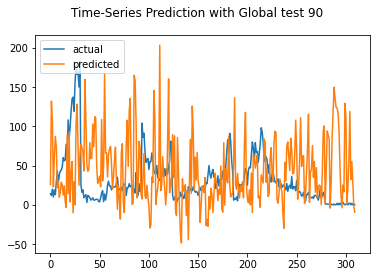

Restoring model weights from the end of the best epoch.
Epoch 00025: early stopping
Test MAE: 39.881
Test RMSE: 49.531
Test sMAPE: 127.931
Test R Squared: -1.473
{'mae': 39.88075101827422, 'rmse': 49.53125215188148, 'smape': 127.9310121054776, 'r2': -1.4728259448686978}


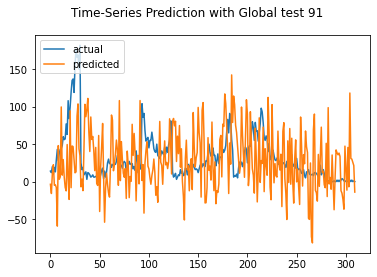

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 36.237
Test RMSE: 44.532
Test sMAPE: 92.385
Test R Squared: -0.999
{'mae': 36.23712848271093, 'rmse': 44.531659833246344, 'smape': 92.3854720396001, 'r2': -0.9988154622736078}


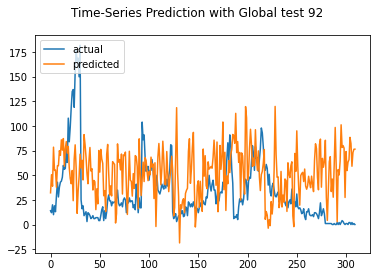

Test MAE: 37.891
Test RMSE: 44.378
Test sMAPE: 93.520
Test R Squared: -0.985
{'mae': 37.89088352264896, 'rmse': 44.37833431000041, 'smape': 93.52012902618522, 'r2': -0.9850750434225559}


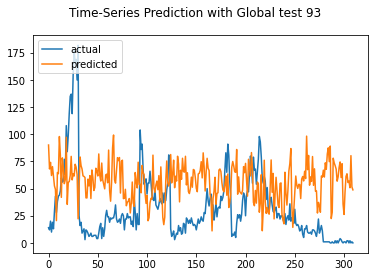

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 38.789
Test RMSE: 46.171
Test sMAPE: 96.250
Test R Squared: -1.149
{'mae': 38.78891322497399, 'rmse': 46.171454249216644, 'smape': 96.25031454835782, 'r2': -1.1487309615524506}


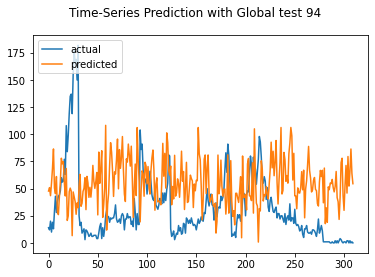

Test MAE: 40.377
Test RMSE: 53.448
Test sMAPE: 96.150
Test R Squared: -1.879
{'mae': 40.377184459663205, 'rmse': 53.448165458529445, 'smape': 96.15017638351269, 'r2': -1.879390323732507}


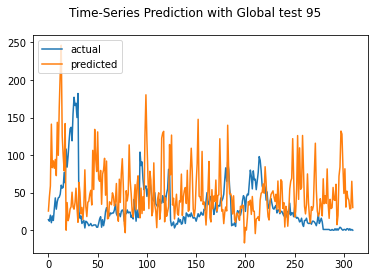

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 36.788
Test RMSE: 44.673
Test sMAPE: 92.779
Test R Squared: -1.011
{'mae': 36.78751425108602, 'rmse': 44.67255625040567, 'smape': 92.7791702051669, 'r2': -1.0114838184470747}


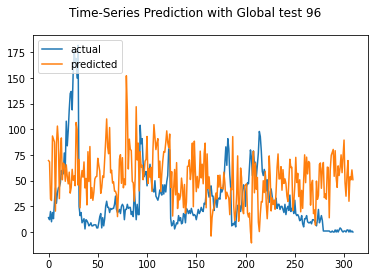

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 39.950
Test RMSE: 46.996
Test sMAPE: 98.647
Test R Squared: -1.226
{'mae': 39.949978996669095, 'rmse': 46.99572738311006, 'smape': 98.64686424724484, 'r2': -1.2261359655313728}


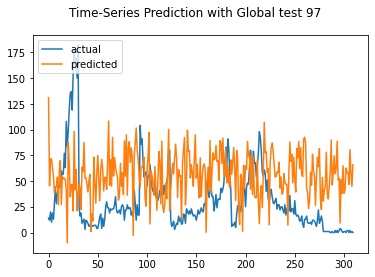

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 35.315
Test RMSE: 43.864
Test sMAPE: 95.823
Test R Squared: -0.939
{'mae': 35.31478669749152, 'rmse': 43.8640774525109, 'smape': 95.82260621038209, 'r2': -0.939335439932913}


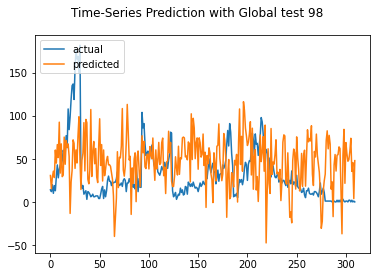

Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
Test MAE: 39.010
Test RMSE: 48.781
Test sMAPE: 114.860
Test R Squared: -1.399
{'mae': 39.010237039289166, 'rmse': 48.7813514701924, 'smape': 114.85985771495659, 'r2': -1.3985158389046655}


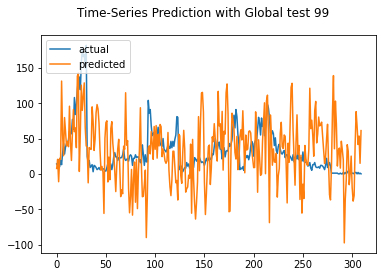

rmse : average=48.509, std=5.327
mae : average=39.388, std=4.551
smape : average=102.740, std=10.664
r2 : average=-1.400, std=0.534


([48.509015191901064, 5.326526151154406],
 [39.38794370846114, 4.550564425677453],
 [102.7402214898949, 10.663644416839354],
 [-1.4004069213839867, 0.5335569975562564])

In [13]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')